<a href="https://colab.research.google.com/github/Lessar277/stable-diffusion-colab/blob/main/pharmapsychotic_Stable_Diffusion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lessar's Stable Diffusion Notebook V0.5

Copy of [Stable Diffusion](https://colab.research.google.com/github/pharmapsychotic/ai-notebooks/blob/main/pharmapsychotic_Stable_Diffusion.ipynb) notebook by [@pharmapsychotic](https://twitter.com/pharmapsychotic) 

This lets you generate images with CompVis/Stability [Stable Diffusion](https://github.com/CompVis/stable-diffusion) with bonus [KLMS sampling](https://github.com/crowsonkb/k-diffusion.git) from [@RiversHaveWings](https://twitter.com/RiversHaveWings)

You need to get the ckpt file and put it on your Google Drive first to use this. It can be downloaded from [HuggingFace](https://huggingface.co/CompVis/stable-diffusion).

## Changelog
V0.5
* Added dpm2, dpm2_a, heun, euler, euler_a samplers
* added the ability to increase step count with each iteration
* added the option to iterate through samplers (basic)
* updated layout (scale step, step increase and sampler iteration now have their own experiments section) 

V0.4
* Added sample_loopback option

V0.3
* Updated to latest pharmapsychotic version, to include mixed precision

V0.2
* Add freeze_seed option
* Add guidance_scale_step option

V0.1
* Added option to reroll with random seed
* Added seed and step value to output name

In [ ]:
#@title Check GPU
!nvidia-smi -L

In [ ]:
#@title Mount Google Drive and Prepare Folders
from google.colab import drive
drive.mount('/content/gdrive')
outputs_path = "/content/gdrive/MyDrive/AI/StableDiffusion"
!mkdir -p $outputs_path
print(f"Outputs will be saved to {outputs_path}")

In [ ]:
#@title Installation
!pip install pytorch-lightning torch-fidelity
!pip install numpy omegaconf einops kornia pytorch-lightning
!pip install albumentations transformers
!pip install ftfy jsonmerge resize-right torchdiffeq tqdm

!git clone https://github.com/CompVis/stable-diffusion
!git clone https://github.com/CompVis/taming-transformers
!git clone https://github.com/openai/CLIP.git
!git clone https://github.com/crowsonkb/k-diffusion.git

!echo '' > ./k-diffusion/k_diffusion/__init__.py


In [ ]:
#@title Load Model

#@markdown You need to get the model weights yourself and put on Google Drive or this Colab instance
checkpoint_model_file = "/content/gdrive/MyDrive/AI/models/sd-v1-4.ckpt" #@param {type:"string"}

import argparse, gc, json, os, random, sys, time, glob, requests
import torch
import torch.nn as nn
import numpy as np
import PIL
from contextlib import contextmanager, nullcontext
from einops import rearrange, repeat
from IPython.display import display, clear_output
from itertools import islice
from omegaconf import OmegaConf
from PIL import Image
from pytorch_lightning import seed_everything
from torch import autocast

sys.path.append("./CLIP")
sys.path.append('./k-diffusion')
sys.path.append('./stable-diffusion')
sys.path.append('./taming-transformers')

from ldm.util import instantiate_from_config
from ldm.models.diffusion.ddim import DDIMSampler
from ldm.models.diffusion.plms import PLMSSampler

from k_diffusion.sampling import sample_lms, sample_euler, sample_euler_ancestral, sample_dpm_2, sample_dpm_2_ancestral, sample_heun
from k_diffusion.external import CompVisDenoiser

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

def chunk(it, size):
    it = iter(it)
    return iter(lambda: tuple(islice(it, size)), ())

def load_model_from_config(config, ckpt, verbose=False):
    print(f"Loading model from {ckpt}")
    pl_sd = torch.load(ckpt, map_location="cpu")
    if "global_step" in pl_sd:
        print(f"Global Step: {pl_sd['global_step']}")
    sd = pl_sd["state_dict"]
    model = instantiate_from_config(config.model)
    m, u = model.load_state_dict(sd, strict=False)
    if len(m) > 0 and verbose:
        print("missing keys:")
        print(m)
    if len(u) > 0 and verbose:
        print("unexpected keys:")
        print(u)

    model = model.half().to(device)
    model.eval()
    return model


class CFGDenoiser(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.inner_model = model

    def forward(self, x, sigma, uncond, cond, cond_scale):
        x_in = torch.cat([x] * 2)
        sigma_in = torch.cat([sigma] * 2)
        cond_in = torch.cat([uncond, cond])
        uncond, cond = self.inner_model(x_in, sigma_in, cond=cond_in).chunk(2)
        return uncond + (cond - uncond) * cond_scale

class config():
    def __init__(self):
        self.ckpt = checkpoint_model_file
        self.config = 'stable-diffusion/configs/stable-diffusion/v1-inference.yaml'
        self.ddim_eta = 0.0
        self.ddim_steps = 100
        self.fixed_code = True
        self.init_img = None
        self.n_iter = 1
        self.n_samples = 1
        self.outdir = ""
        self.precision = 'autocast'
        self.prompt = ""
        self.sampler = 'klms'
        self.scale = 7.5
        self.seed = 42
        self.strength = 0.75 # strength for noising/unnoising. 1.0 corresponds to full destruction of information in init image
        self.H = 512
        self.W = 512
        self.C = 4
        self.f = 8
      
def load_img(path, shape):
    if path.startswith('http://') or path.startswith('https://'):
        image = Image.open(requests.get(path, stream=True).raw).convert('RGB')
    else:
        if os.path.isdir(path):
            files = [file for file in os.listdir(path) if file.endswith('.png') or file .endswith('.jpg')]
            path = os.path.join(path, random.choice(files))
            print(f"Chose random init image {path}")
        image = Image.open(path).convert('RGB')
    image = image.resize(shape, resample=PIL.Image.LANCZOS)
    image = np.array(image).astype(np.float16) / 255.0
    image = image[None].transpose(0, 3, 1, 2)
    image = torch.from_numpy(image)
    return 2.*image - 1.

opt = config()
config = OmegaConf.load(f"{opt.config}")
model = load_model_from_config(config, f"{opt.ckpt}")
model = model.to(device)
batch_idx = 0
sample_idx = 0

def generate(opt):
    global sample_idx
    seed_everything(opt.seed)
    os.makedirs(opt.outdir, exist_ok=True)

    if opt.sampler == 'plms':
        sampler = PLMSSampler(model)
    else:
        sampler = DDIMSampler(model)

    model_wrap = CompVisDenoiser(model)       
    batch_size = opt.n_samples
    prompt = opt.prompt
    assert prompt is not None
    data = [batch_size * [prompt]]
    init_latent = None

    if opt.init_img != None and opt.init_img != '':
        init_image = load_img(opt.init_img, shape=(opt.W, opt.H)).to(device)
        init_image = repeat(init_image, '1 ... -> b ...', b=batch_size)
        init_latent = model.get_first_stage_encoding(model.encode_first_stage(init_image))  # move to latent space

    sampler.make_schedule(ddim_num_steps=opt.ddim_steps, ddim_eta=opt.ddim_eta, verbose=False)

    t_enc = int(opt.strength * opt.ddim_steps)

    start_code = None
    if opt.fixed_code and init_latent == None:
        start_code = torch.randn([opt.n_samples, opt.C, opt.H // opt.f, opt.W // opt.f], device=device)

    images = []
    precision_scope = autocast if opt.precision == "autocast" else nullcontext
    with torch.no_grad():
        with precision_scope("cuda"):
            with model.ema_scope():
                for n in range(opt.n_iter):
                    for prompts in data:
                        uc = None
                        if opt.scale != 1.0:
                            uc = model.get_learned_conditioning(batch_size * [""])
                        if isinstance(prompts, tuple):
                            prompts = list(prompts)
                        c = model.get_learned_conditioning(prompts)

                        if init_latent != None:
                            z_enc = sampler.stochastic_encode(init_latent, torch.tensor([t_enc]*batch_size).to(device))
                            samples = sampler.decode(z_enc, c, t_enc, unconditional_guidance_scale=opt.scale,
                                                    unconditional_conditioning=uc,)
                        else:

                            if opt.sampler in ["klms","dpm2","dpm2_ancestral","heun","euler","euler_ancestral"]:
                                shape = [opt.C, opt.H // opt.f, opt.W // opt.f]
                                sigmas = model_wrap.get_sigmas(opt.ddim_steps)
                                model_wrap_cfg = CFGDenoiser(model_wrap)
                                x = torch.randn([opt.n_samples, *shape], device=device) * sigmas[0]
                                extra_args = {'cond': c, 'uncond': uc, 'cond_scale': opt.scale}
                                if opt.sampler == 'klms':
                                  print("Using KLMS sampling")
                                  samples = sample_lms(model_wrap_cfg, x, sigmas, extra_args=extra_args, disable=False)
                                elif opt.sampler == 'dpm2':
                                  print("Using dpm2 sampling")
                                  samples = sample_dpm_2(model_wrap_cfg, x, sigmas, extra_args=extra_args, disable=False)
                                elif opt.sampler == 'dpm2_ancestral':
                                  print("Using dpm2_ancestral sampling")
                                  samples = sample_dpm_2_ancestral(model_wrap_cfg, x, sigmas, extra_args=extra_args, disable=False)
                                elif opt.sampler == 'heun':
                                  print("Using heun sampling")
                                  samples = sample_heun(model_wrap_cfg, x, sigmas, extra_args=extra_args, disable=False)
                                elif opt.sampler == 'euler':
                                  print("Using euler sampling")
                                  samples = sample_euler(model_wrap_cfg, x, sigmas, extra_args=extra_args, disable=False)
                                elif opt.sampler == 'euler_ancestral':
                                  print("Using euler_ancestral sampling")
                                  samples = sample_euler_ancestral(model_wrap_cfg, x, sigmas, extra_args=extra_args, disable=False)
                            else:
                                shape = [opt.C, opt.H // opt.f, opt.W // opt.f]
                                samples, _ = sampler.sample(S=opt.ddim_steps,
                                                                conditioning=c,
                                                                batch_size=opt.n_samples,
                                                                shape=shape,
                                                                verbose=False,
                                                                unconditional_guidance_scale=opt.scale,
                                                                unconditional_conditioning=uc,
                                                                eta=opt.ddim_eta,
                                                                x_T=start_code)

                        x_samples = model.decode_first_stage(samples)
                        x_samples = torch.clamp((x_samples + 1.0) / 2.0, min=0.0, max=1.0)

                        for x_sample in x_samples:
                            x_sample = 255. * rearrange(x_sample.cpu().numpy(), 'c h w -> h w c')
                            images.append(Image.fromarray(x_sample.astype(np.uint8)))
                            filepath = os.path.join(opt.outdir, f"{batch_name}({batch_idx})_{sample_idx:04}_seed_{opt.seed}_scale_{opt.scale}_sampler_{opt.sampler}.png")
                            print(f"Saving to {filepath}")
                            Image.fromarray(x_sample.astype(np.uint8)).save(filepath)
                            sample_idx += 1
    return images



Used seed: 2492944439
Saved to: /content/gdrive/MyDrive/AI/StableDiffusion/own notebook sampler test/own notebook sampler test(2)_0007_seed_2492944439_scale_8_sampler_plms.png


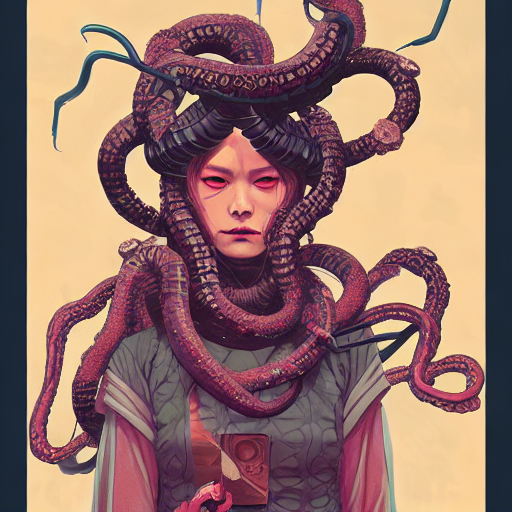

In [9]:

#@title ##Image creation

#@markdown `batch_name`: name for subfolder and filenames<br>
#@markdown `width_height`: image dimensions<br>
#@markdown `guidance_scale`: strength of text prompt<br>
#@markdown `steps`: number of diffusion steps<br>
#@markdown `num_batch_images`: how many images you want to generate in this batch<br>
#@markdown `sampler`: KLMS is recommended<br>
#@markdown `ddim_eta`: scale of variance from 0.0 to 1.0<br>
#@markdown `seed`: use -1 for random seed or specify number manually<br>
#@markdown `freeze_seed`: keep the same seed between iterations (useful together with guidance_scale_step)<br>
#@markdown `random_seed_reroll`: if you want a random seed everytime. If false, it will increment initial seed by 1<br><br>

#@markdown ###Batch settings
batch_name = "medusa" #@param {type:"string"}
width_height = [512, 512] #@param{type: 'raw'}
guidance_scale = 7.5 #@param {type:"number"}
steps = 50 #@param {type:"integer"}
samples_per_batch = 1 # not exposed, you can do 2 or more based on GPU ram, if get CUDA out of memory need to restart runtime
num_batch_images = 8 #@param {type:"integer"}
sampler = 'klms' #@param ["klms","dpm2","dpm2_ancestral","heun","euler","euler_ancestral","plms", "ddim"]
ddim_eta = 0 #@param {type:"number"}
seed = -1 #@param {type:"integer"}
freeze_seed = False #@param {type: "boolean"}
random_seed_reroll = True #@param {type: "boolean"}

#@markdown ###Experiments

#@markdown `guidance_scale_step`: increase guidance_scale by this much for each iteration<br>
#@markdown `step_increase`: increase steps value by this much for each iteration<br>
#@markdown `iterate_samplers`: switch samplers with each generation. This will always start with KLMS, regardless of what sampler was chosen above. Recommended to run exactly 8 batches for this experiment. No effect if num_batch_images is greater than 8 <br>

guidance_scale_step = 0 #@param {type:"number"}
step_increase = 0 #@param {type:"number"}
iterate_samplers = False #@param {type:"boolean"}

#@markdown 

#@markdown ###Init image

#@markdown `init_image_or_folder`: url or path to an image, or path to a folder to pick random images from<br>
#@markdown `init_strength`: from 0.0 to 1.0 how much the init image is used<br>
#@markdown `sample_loopback`: use the generated image as `init_image` for the next iteration ⚠️ Not compatible with PLMS


init_image_or_folder = "" #@param {type:"string"}
init_strength = 0.3 #@param {type:"number"}
sample_loopback = False #@param {type:"boolean"}

#@markdown 

#@markdown ###Prompt
prompt = "portrait of cyberpunk medusa by shaun tan and greg rutkowski and sachin teng in the style of ukiyo-e" #@param {type:"string"}


opt.init_img = init_image_or_folder
opt.sample_loopback = sample_loopback
opt.ddim_steps = steps
opt.n_iter = 1
opt.n_samples = samples_per_batch
opt.outdir = os.path.join(outputs_path, batch_name)
opt.prompt = prompt
opt.sampler = sampler
opt.scale = guidance_scale
opt.seed = random.randint(0, 2**32) if seed == -1 else seed
opt.strength = max(0.0, min(1.0, 1.0 - init_strength))
opt.W, opt.H = map(lambda x: x - x % 64, (width_height[0], width_height[1])) # resize to integer multiple of 64

if opt.strength >= 1 or init_image_or_folder == None:
    opt.init_img = ""

if opt.init_img != None and opt.init_img != '':
    opt.sampler = 'ddim'

if opt.sampler != 'ddim':
    opt.ddim_eta = 0.0

# save settings
settings = {
    'ddim_eta': ddim_eta,
    'guidance_scale': guidance_scale,
    'guidance_scale_step': guidance_scale_step,
    'step_increase': step_increase,
    'init_image': init_image_or_folder,
    'init_strength': init_strength,
    'num_batch_images': num_batch_images,
    'prompt': prompt,
    'sampler': sampler,
    'iterate_samplers': iterate_samplers,
    'samples_per_batch': samples_per_batch,
    'seed': opt.seed,
    'freeze_seed': freeze_seed,
    'random_seed_reroll': random_seed_reroll,
    'steps': steps,
    'width': opt.W,
    'height': opt.H,
}
os.makedirs(opt.outdir, exist_ok=True)
while os.path.isfile(f"{opt.outdir}/{batch_name}({batch_idx})_settings.txt"):
    batch_idx += 1
with open(f"{opt.outdir}/{batch_name}({batch_idx})_settings.txt", "w+", encoding="utf-8") as f:
    json.dump(settings, f, ensure_ascii=False, indent=4)
sample_idx = 0

for i in range(num_batch_images):
    gc.collect()
    torch.cuda.empty_cache()
    sample_filepath = os.path.join(opt.outdir, f"{batch_name}({batch_idx})_{sample_idx:04}_seed_{opt.seed}_scale_{opt.scale}_sampler_{opt.sampler}.png")
    sampler_list = ["klms","dpm2","dpm2_ancestral","heun","euler","euler_ancestral","plms", "ddim"]
    if iterate_samplers == True and opt.n_iter <= 8:
      opt.sampler = sampler_list[sample_idx]
      
    images = generate(opt)
    
    clear_output(wait=True)
    print(f"Used seed: {opt.seed}")
    print(f"Saved to: {sample_filepath}")
    for image in images:
        display(image)

    if freeze_seed == False:
        opt.seed = random.randint(0, 2**32) if random_seed_reroll == True else opt.seed + 1
    opt.scale = opt.scale + guidance_scale_step
    opt.ddim_steps = opt.ddim_steps + step_increase
    if sample_loopback == True:
      print("Waiting for image to be saved to googleDrive (up to 1 min)");
      time_to_wait = 60
      time_counter = 0
      while not os.path.exists(sample_filepath):
        time.sleep(1)
        time_counter += 1
        if time_counter > time_to_wait:break
      print("Image found")
      opt.init_img = sample_filepath
